In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.spatial as spa
import os
import scipy.stats as stats
from scipy.stats import multivariate_normal
import pandas as pd
from math import e, pow


In [2]:
# define given paramters
class_means = np.array([[+5.0, +5.0],
                        [-5.0, +5.0],
                        [-5.0, -5.0],
                        [+5.0, -5.0],
                        [+5.0, +0.0],
                        [+0.0, +5.0],
                        [-5.0, +0.0],
                        [+0.0, -5.0],
                        [+0.0, +0.0]])
class_covariances = np.array([[[+0.8, -0.6], [-0.6, +0.8]],
                             [[+0.8, +0.6], [+0.6, +0.8]],
                             [[+0.8, -0.6], [-0.6, +0.8]],
                             [[+0.8, +0.6], [+0.6, +0.8]],
                             [[+0.2, 0], [0, +1.2]],
                             [[+1.2, 0], [0, +0.2]],
                             [[+1.2, 0], [0, +0.2]],
                             [[+0.2, 0], [0, +1.2]],
                             [[+1.2, 0], [0, +0.2]],
                             [[+1.6, 0], [0, +1.6]]])

class_sizes = np.array([100, 100, 100, 100, 100, 100, 100, 100, 200])


In [3]:
# Importing Data Set
dataset = np.genfromtxt("hw08_data_set.csv", delimiter=',')
init_centroids = np.genfromtxt("hw08_initial_centroids.csv", delimiter=',')

N = sum(class_sizes)
K = len(class_sizes)


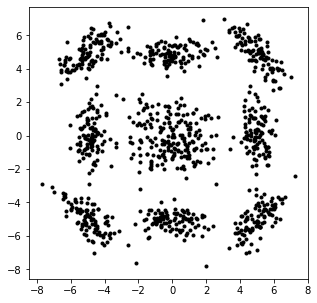

In [4]:
#plot dataset 
plt.figure(figsize=(5, 5))
plt.plot(dataset[:, 0], dataset[:, 1], ".", color="k")
plt.show()


In [5]:
cluster_colors = np.array(["#1f78b4", "#33a02c", "#e31a1c", "#ff7f00", "#6a3d9a", "#b15928",
                           "#a6cee3", "#b2df8a", "#fb9a99"])


In [6]:

# Three useful functions which are taken from the lab session
def update_centroids(memberships, X):
    if memberships is None:
        # initialize centroids
        centroids = X[np.random.choice(range(N), K, False), :]
    else:
        # update centroids
        centroids = np.vstack(
            [np.mean(X[memberships == k, :], axis=0) for k in range(K)])
    return(centroids)


def update_memberships(centroids, X):
    # calculate distances between centroids and data points
    D = spa.distance_matrix(centroids, X)
    # find the nearest centroid for each data point
    memberships = np.argmin(D, axis=0)
    return(memberships)


def plot_current_state(centroids, memberships, X):

    if memberships is None:
        plt.plot(X[:, 0], X[:, 1], ".", markersize=10, color="black")
    else:
        for c in range(K):
            plt.plot(X[memberships == c, 0], X[memberships == c, 1], ".", markersize=10,
                     color=cluster_colors[c])
    for c in range(K):
        plt.plot(centroids[c, 0], centroids[c, 1], "s", markersize=12,
                 markerfacecolor=cluster_colors[c], markeredgecolor="black")
    plt.xlabel("x1")
    plt.ylabel("x2")


In [7]:
def E_step(means, covariances, prior_probabilities, X):
    memberships = np.zeros((N, K))
    for k in range(K):
        for i in range(N):
            memberships[i, k] = stats.multivariate_normal.pdf(X[i], means[k], covariances[k]) * prior_probabilities[k] / np.sum([stats.multivariate_normal.pdf(X[i], means[c], covariances[c]) * prior_probabilities[c] for c in range(K)], axis = 0)
    return memberships


In [8]:
def M_step(memberships, X):
    means = np.zeros((K, X.shape[1]))
    covariances = np.zeros((K, X.shape[1], X.shape[1]))
    prior_probabilities = np.zeros((K))
    for k in range(K):
        means[k] = np.sum([np.multiply(X[i], memberships[i, k]) for i in range(N)], axis = 0) / np.sum(memberships[range(N), k])
        covariances[k] = np.sum([np.multiply(np.matmul(np.transpose(np.asmatrix(X[i] - means[k])), np.asmatrix(X[i] - means[k])), memberships[i, k]) for i in range(N)], axis = 0) / np.sum(memberships[range(N), k])
        prior_probabilities[k] = np.sum(memberships[range(N), k], axis = 0) / N
    return means, covariances, prior_probabilities

In [9]:
#initialization
means = init_centroids
X=dataset
D = spa.distance_matrix(means, X)
memberships = np.zeros((N, K))
memberships[range(N), np.argmin(D, axis = 0)] = 1

covariances = np.zeros((K, X.shape[1], X.shape[1]))
for k in range(K):
    covariances[k] = np.sum([np.multiply(np.matmul(np.transpose(np.asmatrix(X[i] - means[k])), np.asmatrix(X[i] - means[k])), memberships[i, k]) for i in range(N)], axis = 0) / np.sum(memberships[range(N), k])

prior_probabilities = np.sum(memberships, axis = 0) / N


In [10]:
#This for loop takes about 16 minutes to complete 
for i in range(100):
    means, covariances, prior_probabilities = M_step(memberships, X)
    memberships = E_step(means, covariances, prior_probabilities, X)

In [11]:

print(means)

[[-4.9508988  -4.98464367]
 [-4.85629614  0.0404331 ]
 [-4.96379877  4.984647  ]
 [ 0.02477868 -5.09014979]
 [-0.09548618 -0.116943  ]
 [-0.03701877  4.91812108]
 [ 5.00933942 -5.02595861]
 [ 4.99839618  0.13777844]
 [ 4.96705774  4.97185503]]


In [12]:
memberships.shape

(1000, 9)

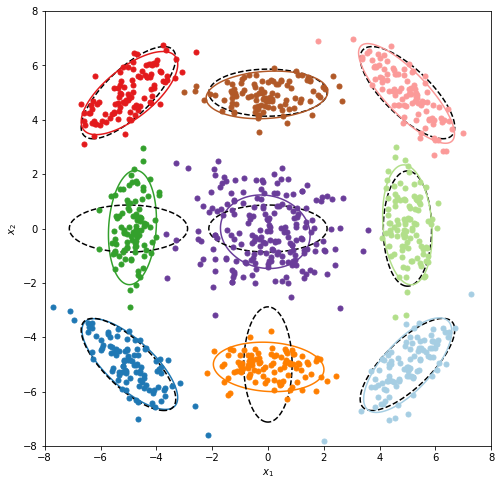

In [13]:
fig = plt.figure(figsize = (8, 8))

memberships_final = np.argmax(memberships, axis = 1)


x1 = np.linspace(-8,8,1601)  
x2 = np.linspace(-8,8,1601)
XX, Y = np.meshgrid(x1, x2) 
pos = np.empty(XX.shape + (2,))                
pos[:, :, 0] = XX; pos[:, :, 1] = Y

for c in range(K):
    plt.plot(X[memberships_final == c, 0], X[memberships_final == c, 1], ".", markersize = 10, 
                color = cluster_colors[c])
    plt.contour(XX, Y, stats.multivariate_normal(class_means[c], class_covariances[c]).pdf(pos), levels=[0.05],colors = "black", linestyles = "dashed")
    plt.contour(XX, Y, stats.multivariate_normal(means[c], covariances[c]).pdf(pos), levels=[0.05], colors = cluster_colors[c], linestyles = "solid")
    
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.show()